<a href="https://colab.research.google.com/github/rishabh-bhardwaj-64rr/EVA5/blob/master/S9/QuizDNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model Architecture**
```
x1 = Input
x2 = Conv(x1)
x3 = Conv(x1 + x2)
x4 = MaxPooling(x1 + x2 + x3)
x5 = Conv(x4)
x6 = Conv(x4 + x5)
x7 = Conv(x4 + x5 + x6)
x8 = MaxPooling(x5 + x6 + x7)
x9 = Conv(x8)
x10 = Conv (x8 + x9)
x11 = Conv (x8 + x9 + x10)
x12 = GAP(x11)
x13 = FC(x12)

```

In [16]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-09-26 22:46:36.070091


In [1]:
!git clone https://github.com/rishabh-bhardwaj-64rr/EVA5

Cloning into 'EVA5'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 359 (delta 45), reused 12 (delta 1), pack-reused 269
Receiving objects: 100% (359/359), 2.40 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (173/173), done.


In [2]:
cd EVA5/S9/

/content/EVA5/S9


In [3]:
from __future__ import print_function

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

import albumentations as A
import albumentations.pytorch.transforms as APT

In [4]:

from data_loading import transform, dataset, dataloader
from models import resnet, QuizDNN
import normalisation as norm, loss_functions, trainer, tester, run_model
from utils import plot_metrics, misclassifications, classwise_accuracy
import run_grad_cam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

In [6]:
# train_transforms, test_transforms = transform.cifar10_transforms(mean, std)
train_transforms, test_transforms = transform.cifar10_albumentations(mean, std)
trainset, testset = dataset.cifar10_dataset(train_transforms, test_transforms)
train_loader, test_loader = dataloader.cifar10_dataloader(trainset, testset)
# ToTensorV2()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA available? True


In [7]:
# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [8]:
# classes in the data
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
# model summary
net = QuizDNN.QuizDNN().to(device)
print(summary(net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             256
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [10]:
EPOCHS = 40
optimizer = optim.SGD(net.parameters(), lr = 0.005, momentum = 0.9)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

run_model.evaluation( net, train_loader, test_loader, optimizer, EPOCHS, device,
                    train_acc, train_losses, test_acc, test_losses)

  0%|          | 0/391 [00:00<?, ?it/s]


 Epoch: 1


Loss = 1.3565751314163208 Batch_id = 390 Accuracy = 37.66: 100%|██████████| 391/391 [00:28<00:00, 13.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 4299/10000 (42.99%)


 Epoch: 2


Loss = 1.2968518733978271 Batch_id = 390 Accuracy = 51.33: 100%|██████████| 391/391 [00:28<00:00, 13.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 5056/10000 (50.56%)


 Epoch: 3


Loss = 1.244489073753357 Batch_id = 390 Accuracy = 57.73: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 4448/10000 (44.48%)


 Epoch: 4


Loss = 1.0883082151412964 Batch_id = 390 Accuracy = 61.58: 100%|██████████| 391/391 [00:28<00:00, 13.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 5159/10000 (51.59%)


 Epoch: 5


Loss = 0.874727725982666 Batch_id = 390 Accuracy = 64.62: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 4938/10000 (49.38%)


 Epoch: 6


Loss = 0.8612993955612183 Batch_id = 390 Accuracy = 67.18: 100%|██████████| 391/391 [00:28<00:00, 13.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6489/10000 (64.89%)


 Epoch: 7


Loss = 0.868514358997345 Batch_id = 390 Accuracy = 69.14: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6549/10000 (65.49%)


 Epoch: 8


Loss = 0.6473357677459717 Batch_id = 390 Accuracy = 71.21: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6154/10000 (61.54%)


 Epoch: 9


Loss = 0.6231183409690857 Batch_id = 390 Accuracy = 72.36: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 5945/10000 (59.45%)


 Epoch: 10


Loss = 0.6334025859832764 Batch_id = 390 Accuracy = 73.89: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 6100/10000 (61.00%)


 Epoch: 11


Loss = 0.8264662623405457 Batch_id = 390 Accuracy = 74.69: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7462/10000 (74.62%)


 Epoch: 12


Loss = 0.8250633478164673 Batch_id = 390 Accuracy = 75.79: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6446/10000 (64.46%)


 Epoch: 13


Loss = 0.6724529266357422 Batch_id = 390 Accuracy = 76.46: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 4895/10000 (48.95%)


 Epoch: 14


Loss = 0.5481246709823608 Batch_id = 390 Accuracy = 77.15: 100%|██████████| 391/391 [00:28<00:00, 13.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 6561/10000 (65.61%)


 Epoch: 15


Loss = 0.565796971321106 Batch_id = 390 Accuracy = 77.94: 100%|██████████| 391/391 [00:28<00:00, 13.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 5565/10000 (55.65%)


 Epoch: 16


Loss = 0.5104126930236816 Batch_id = 390 Accuracy = 78.37: 100%|██████████| 391/391 [00:28<00:00, 13.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 6651/10000 (66.51%)


 Epoch: 17


Loss = 0.48489928245544434 Batch_id = 390 Accuracy = 78.76: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7581/10000 (75.81%)


 Epoch: 18


Loss = 0.614993155002594 Batch_id = 390 Accuracy = 79.47: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 6384/10000 (63.84%)


 Epoch: 19


Loss = 0.6806769371032715 Batch_id = 390 Accuracy = 80.08: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6999/10000 (69.99%)


 Epoch: 20


Loss = 0.608341634273529 Batch_id = 390 Accuracy = 80.42: 100%|██████████| 391/391 [00:28<00:00, 13.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7545/10000 (75.45%)


 Epoch: 21


Loss = 0.5108126401901245 Batch_id = 390 Accuracy = 80.82: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7646/10000 (76.46%)


 Epoch: 22


Loss = 0.635866641998291 Batch_id = 390 Accuracy = 81.21: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 6542/10000 (65.42%)


 Epoch: 23


Loss = 0.5018571019172668 Batch_id = 390 Accuracy = 81.71: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7853/10000 (78.53%)


 Epoch: 24


Loss = 0.43837738037109375 Batch_id = 390 Accuracy = 81.69: 100%|██████████| 391/391 [00:28<00:00, 13.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7425/10000 (74.25%)


 Epoch: 25


Loss = 0.4720260500907898 Batch_id = 390 Accuracy = 82.24: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7335/10000 (73.35%)


 Epoch: 26


Loss = 0.532079815864563 Batch_id = 390 Accuracy = 82.00: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 7169/10000 (71.69%)


 Epoch: 27


Loss = 0.45512285828590393 Batch_id = 390 Accuracy = 82.65: 100%|██████████| 391/391 [00:27<00:00, 14.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7345/10000 (73.45%)


 Epoch: 28


Loss = 0.4065381586551666 Batch_id = 390 Accuracy = 82.90: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 6985/10000 (69.85%)


 Epoch: 29


Loss = 0.4563785493373871 Batch_id = 390 Accuracy = 83.17: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7867/10000 (78.67%)


 Epoch: 30


Loss = 0.4683307111263275 Batch_id = 390 Accuracy = 83.32: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 7157/10000 (71.57%)


 Epoch: 31


Loss = 0.3752937912940979 Batch_id = 390 Accuracy = 83.61: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7689/10000 (76.89%)


 Epoch: 32


Loss = 0.48377618193626404 Batch_id = 390 Accuracy = 83.59: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 6842/10000 (68.42%)


 Epoch: 33


Loss = 0.33494412899017334 Batch_id = 390 Accuracy = 84.12: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7457/10000 (74.57%)


 Epoch: 34


Loss = 0.47858160734176636 Batch_id = 390 Accuracy = 84.33: 100%|██████████| 391/391 [00:28<00:00, 13.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8044/10000 (80.44%)


 Epoch: 35


Loss = 0.4357973039150238 Batch_id = 390 Accuracy = 84.33: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7338/10000 (73.38%)


 Epoch: 36


Loss = 0.2910698652267456 Batch_id = 390 Accuracy = 84.64: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7884/10000 (78.84%)


 Epoch: 37


Loss = 0.6323674321174622 Batch_id = 390 Accuracy = 84.72: 100%|██████████| 391/391 [00:27<00:00, 14.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7784/10000 (77.84%)


 Epoch: 38


Loss = 0.36380407214164734 Batch_id = 390 Accuracy = 84.77: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8337/10000 (83.37%)


 Epoch: 39


Loss = 0.5051663517951965 Batch_id = 390 Accuracy = 85.07: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7369/10000 (73.69%)


 Epoch: 40


Loss = 0.3173789381980896 Batch_id = 390 Accuracy = 85.09: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]



Test set: Average loss: 0.0057, Accuracy: 7758/10000 (77.58%)



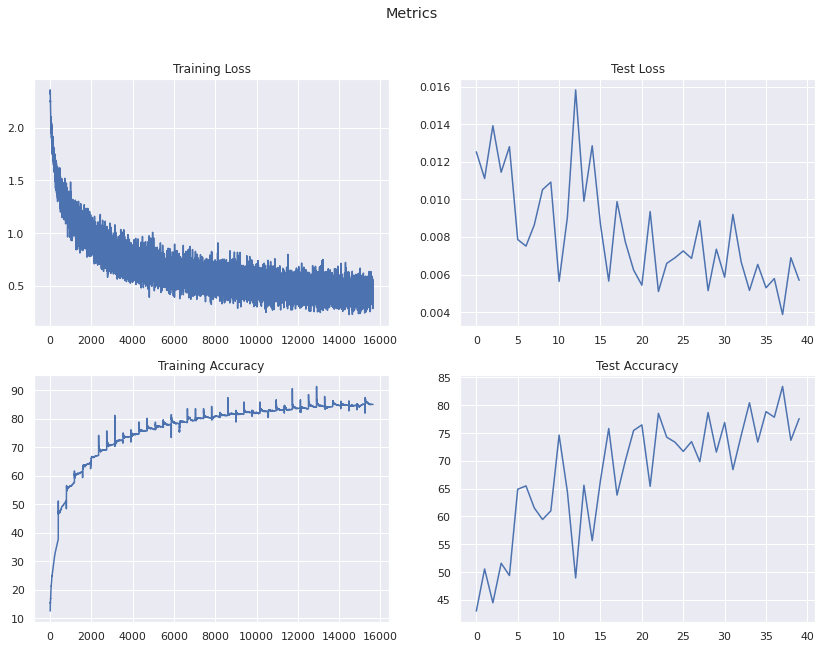

In [11]:
train_metric = (train_acc, train_losses)
test_metric = (test_acc, test_losses)

plot_metrics.metrics(train_metric, test_metric)

In [12]:
# classwise accuracy
classwise_accuracy.classwise_accuracy(net, test_loader, device, classes)

Accuracy of plane : 100 %
Accuracy of   car : 88 %
Accuracy of  bird : 66 %
Accuracy of   cat : 57 %
Accuracy of  deer : 52 %
Accuracy of   dog : 62 %
Accuracy of  frog : 85 %
Accuracy of horse : 96 %
Accuracy of  ship : 58 %
Accuracy of truck : 92 %
